In [2]:
from utils import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.morphology import skeletonize

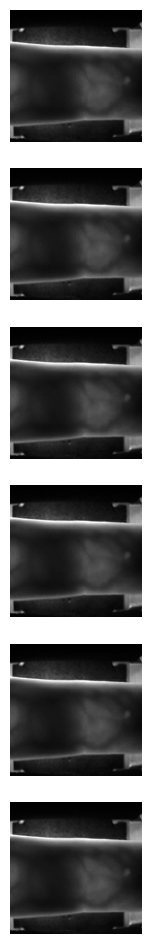

In [3]:
input_imgs = [
    '../data/fingervein-uniform_128/011_rightflipped_middle_1.bmp',
    '../data/fingervein-uniform_128/011_rightflipped_middle_2.bmp',
    '../data/fingervein-uniform_128/011_rightflipped_middle_3.bmp',
    '../data/fingervein-uniform_128/011_rightflipped_middle_4.bmp',
    '../data/fingervein-uniform_128/011_rightflipped_middle_5.bmp',
    '../data/fingervein-uniform_128/011_rightflipped_middle_6.bmp',
]


imgs = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in input_imgs]

fig, ax = plt.subplots(len(imgs), 1, figsize=(2, 12))
    
for i, img in enumerate(imgs):
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')

In [4]:
def rotate_image_90(img):
    return np.rot90(img, 2)

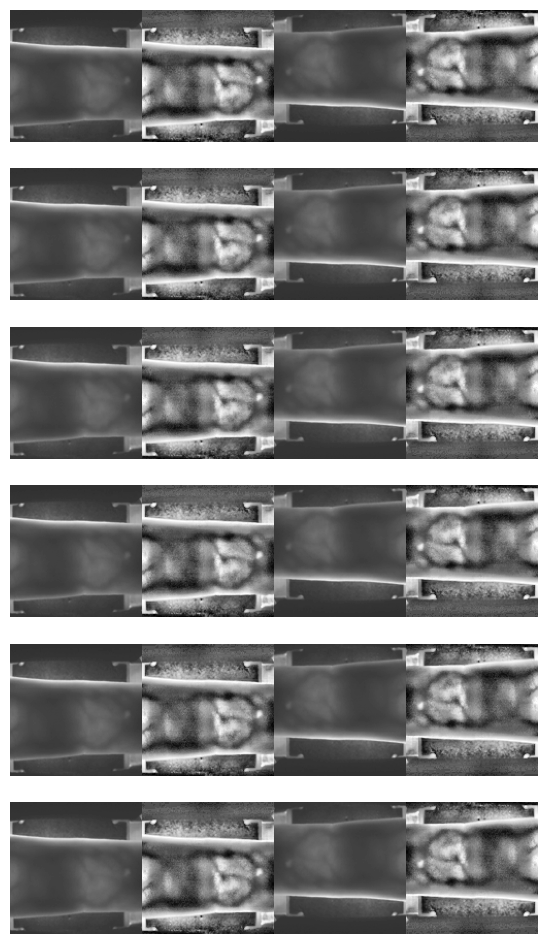

In [5]:
clip_limit = 16
grid_size = (8, 8)

imgs_eq = [clahe(img, clip_limit, grid_size) for img in imgs]
imgs_rot = [rotate_image_90(img) for img in imgs]
imgs_rot_eq = [clahe(img, clip_limit, grid_size) for img in imgs_rot]

fig, ax = plt.subplots(len(imgs), 1, figsize=(8, 12))
    
for i, img in enumerate(imgs):
    img_show = cv2.hconcat([img, imgs_eq[i], imgs_rot[i], imgs_rot_eq[i]])
    ax[i].imshow(img_show, cmap='gray')
    ax[i].axis('off')

In [6]:
def gabor_filter(ksize, sigma, theta, lambd, gamma, psi):
    kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi)
    kern /= np.max(np.abs(kern))
    return kern

In [7]:
def display_filter(filter):

    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    
    ax.imshow(filter, cmap='gray', interpolation='none')
    ax.axis('off')
    

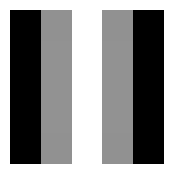

In [8]:
# Define your custom parameters
ksize = 5
theta = np.pi  # Vertical orientation
sigma = 3.0
lambd = 5
gamma = 0.1
psi = 0

filter = gabor_filter(ksize, sigma, theta, lambd, gamma, psi)

display_filter(filter)

In [9]:
def invert(img):
    return 255 - img

In [10]:
def apply_filter(image, filter):
    filtered_img = cv2.filter2D(image, cv2.CV_8UC3, filter)
    return filtered_img


In [11]:
def remove_lines(original_image, gabor_filtered_image, threshold):
    # Threshold the Gabor-filtered image to identify lines
    _, binary_lines = cv2.threshold(gabor_filtered_image, threshold, 255, cv2.THRESH_BINARY)

    # Subtract the lines from the original image
    result_image = cv2.subtract(original_image, binary_lines)

    return result_image

In [12]:
# inverted_img = invert(img_eq)
# inverted_img = img_eq
# filtered_img = apply_filter(inverted_img, filter)
# filtered2_img = remove_lines(inverted_img, filtered_img, 250)
# 
# img_show = cv2.hconcat([img_eq, inverted_img, filtered_img, filtered2_img])
# fig, ax = plt.subplots(1, 1, figsize=(8, 2))
# ax.imshow(img_show, cmap='gray', interpolation='none')
# ax.axis('off')

In [13]:
def gaussian_blur(img, ksize, sigma):
    return cv2.GaussianBlur(img, (ksize, ksize), sigma)

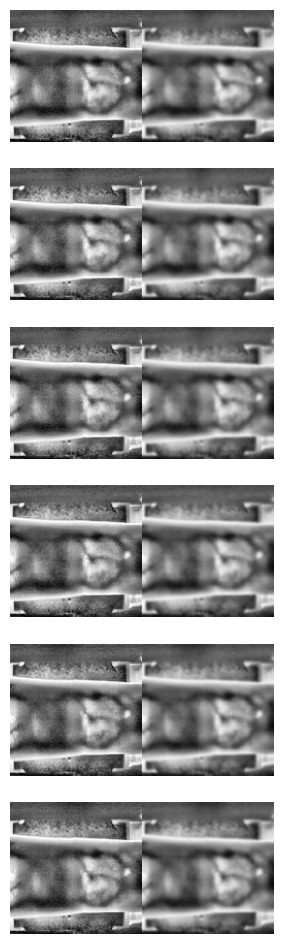

In [14]:
gaussian_blur_imgs = [gaussian_blur(img, 5, 1) for img in imgs_eq]

fig, ax = plt.subplots(len(imgs), 1, figsize=(4, 12))

for i, img in enumerate(imgs_eq):
    img_show = cv2.hconcat([img, gaussian_blur_imgs[i]])
    ax[i].imshow(img_show, cmap='gray')
    ax[i].axis('off')

In [15]:
def increase_contrast(img, alpha=1.0, beta=0):
    """
    Increase the contrast of an image. 
    `alpha` is the contrast control (1.0-3.0)
    `beta` is the brightness control (0-100)
    """
    adjusted = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return adjusted

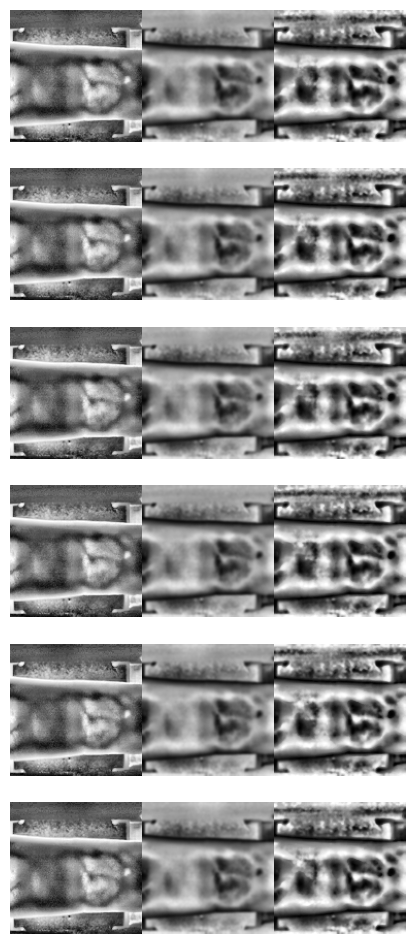

In [16]:
clip_limit_2 = 10
grid_size_2 = (8, 8)

inverted_gaussian_imgs = [invert(img) for img in gaussian_blur_imgs]
inverted_gaussian_imgs_eq = [clahe(img, clip_limit_2, grid_size_2) for img in inverted_gaussian_imgs]

fig, ax = plt.subplots(len(imgs), 1, figsize=(6, 12))

for i, img in enumerate(imgs_eq):
    img_show = cv2.hconcat([img, inverted_gaussian_imgs[i], inverted_gaussian_imgs_eq[i]])
    ax[i].imshow(img_show, cmap='gray')
    ax[i].axis('off')


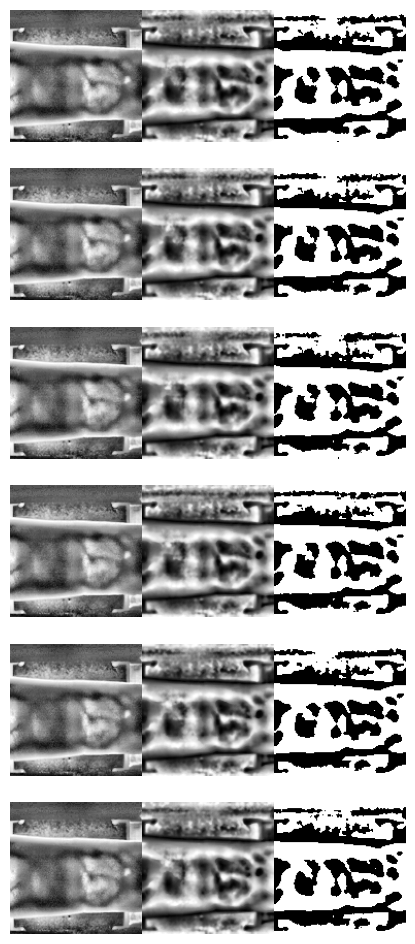

In [21]:
threshold = 110

imgs_thresh = [binary_thresholder(img, threshold=threshold) for img in inverted_gaussian_imgs_eq]

fig, ax = plt.subplots(len(imgs), 1, figsize=(6, 12))

for i, img in enumerate(imgs_eq):
    img_show = cv2.hconcat([img, inverted_gaussian_imgs_eq[i], imgs_thresh[i]])
    ax[i].imshow(img_show, cmap='gray')
    ax[i].axis('off')

In [22]:
def thin_lines(image, iterations):
    # Convert the image to binary (assuming lines are white on a black background)
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

    # Define a kernel for erosion
    kernel = np.ones((3, 3), np.uint8)

    # Apply erosion iteratively
    for _ in range(iterations):
        binary_image = cv2.erode(binary_image, kernel, iterations=1)

    return binary_image

In [23]:
def isolate_finger(thresh_image):
    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Identify the contour corresponding to the central section
    central_contour = max(contours, key=cv2.contourArea)

    # Create a mask for the central section
    mask = np.zeros_like(thresh_image)
    cv2.drawContours(mask, [central_contour], -1, 255, thickness=cv2.FILLED)


    # Keep only the central section using the mask
    result_image = cv2.bitwise_and(thresh_image, mask)

    return result_image

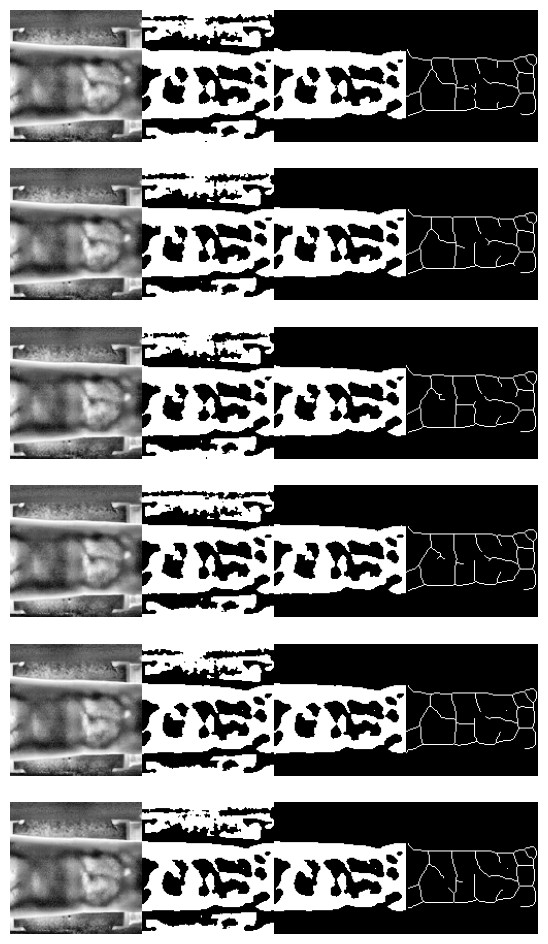

In [24]:
isolate_finger_imgs = [isolate_finger(img) for img in imgs_thresh]
skeletons = [skeletonize(img).astype(np.uint8)*255 for img in isolate_finger_imgs]   

fig, ax = plt.subplots(len(imgs), 1, figsize=(8, 12))

for i, img in enumerate(imgs_eq):
    img_show = cv2.hconcat([img, imgs_thresh[i], isolate_finger_imgs[i], skeletons[i]])
    ax[i].imshow(img_show, cmap='gray')
    ax[i].axis('off')